In [1]:
# set AWS credentials file ~/.aws/credentials or load environment variables to load data from Metaflow
%env MLFLOW_TRACKING_URI=http://localhost:5000
%env AWS_ACCESS_KEY_ID=admin
%env AWS_SECRET_ACCESS_KEY=s3secret

env: MLFLOW_TRACKING_URI=http://localhost:5000
env: AWS_ACCESS_KEY_ID=admin
env: AWS_SECRET_ACCESS_KEY=s3secret


In [2]:
from metaflow import Flow, Step, get_metadata
print("Current metadata provider: %s" % get_metadata())

run = Flow("TrainFlow").latest_successful_run
print("Using run: %s" % str(run))

#Step(f"TrainFlow/{run.id}/start").task.data.vectorizer
best_clf = run.data.best_clf
best_vectorizer = run.data.vectorizer
best_clf.alpha

Current metadata provider: service@http://localhost:8080
Using run: Run('TrainFlow/1')


0.5

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb

In [4]:
train_df = pd.read_csv("./docker/datasets/twitter-train.csv")
test_df = pd.read_csv("./docker/datasets/twitter-test.csv")
train_df.head()
#train_df[train_df.keyword == "wreck"]
#train_df.dtypes

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# could also append keyword but does not improve performance: train_df["keyword"].fillna('').str.replace("%20", " ") + " " + 
train_df["text"] = train_df["text"].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
test_df["text"] = test_df["text"].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
train_df = train_df.drop_duplicates(subset=['text'])
print(train_df.groupby(["keyword", "target"])["target"].count().tail())
#print(train_df[train_df["id"] == 7772].values)

keyword   target
wreck     0         30
          1          7
wreckage  1         37
wrecked   0         36
          1          3
Name: target, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['target'], test_size=0.20, random_state=1, stratify=train_df['target'])
print(X_train['target'].value_counts(normalize=True))
print(X_test['target'].value_counts(normalize=True))

0    0.573809
1    0.426191
Name: target, dtype: float64
0    0.573618
1    0.426382
Name: target, dtype: float64


In [7]:
stop_words = ENGLISH_STOP_WORDS.union(["amp", "gt", "rt", "like", "just", "http", "https"])
vectorizer = CountVectorizer(min_df=2, stop_words=stop_words)
#vectorizer = TfidfVectorizer(min_df=2, stop_words=stop_words)
#vectorizer = TfidfVectorizer(min_df=10, max_features=1000, stop_words="english")

train_vectors = vectorizer.fit_transform(X_train["text"])
test_vectors = vectorizer.transform(X_test["text"])

counts = pd.DataFrame(train_vectors.toarray(), columns=vectorizer.get_feature_names_out())
counts.sum().sort_values(ascending=False).head(10)

new          174
people       153
news         150
don          135
emergency    127
video        126
disaster     113
police       110
storm         98
got           97
dtype: int64

In [8]:
print(vectorizer.get_feature_names_out().shape)
models = [MultinomialNB(), LogisticRegression(), SGDClassifier(), LinearSVC(), xgb.XGBClassifier()]
for model in models:
  #print("CV F1 score", cross_validate(model, train_vectors, y_train, cv=3)['test_score'].mean())
  #continue
  model.fit(train_vectors, y_train)
  print("Model:", model)
  print("Train F1", f1_score(y_train, model.predict(train_vectors)))
  print("Test F1", f1_score(y_test, model.predict(test_vectors)), "\n")

(5343,)
Model: MultinomialNB()
Train F1 0.8391492876316333
Test F1 0.7744610281923715 

Model: LogisticRegression()
Train F1 0.9062370921106981
Test F1 0.7529215358931554 

Model: SGDClassifier()
Train F1 0.9595838335334134
Test F1 0.7401448109412709 

Model: LinearSVC()
Train F1 0.9739510837144562
Test F1 0.734920634920635 

Model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
            

{'alpha': 1}
0.8391492876316333
0.7744610281923715


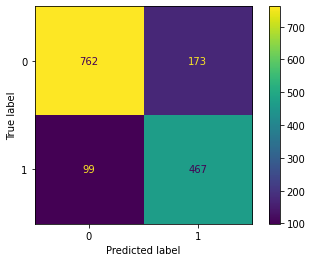

In [9]:
parameters = {'alpha':[0.1, 0.2, 0.5, 0.8, 0.9, 1]}

clf = GridSearchCV(MultinomialNB(), parameters, scoring=["f1", "accuracy"], refit='f1', return_train_score=True, cv=3)
clf.fit(train_vectors, y_train)

#print(clf.cv_results_)
print(clf.best_params_)
#clf = best_clf
print(f1_score(y_train, clf.predict(train_vectors)))
print(f1_score(y_test, clf.predict(test_vectors)))

cm = confusion_matrix(clf.predict(test_vectors), y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [10]:
submit_vectors = vectorizer.transform(test_df["text"])
predictions = clf.predict(submit_vectors)

In [11]:
submit_df = pd.DataFrame({"id": test_df["id"], "target": predictions})
submit_df.to_csv("submission.csv", index=False)

In [12]:
#best_clf
#best_clf.predict(test_vectors)
import mlflow
import pickle
#mlflow.set_tracking_uri("http://localhost:5000")
run_id="f123c7109b6f441a9f37cab2f94dccf9"
logged_model = f'runs:/{run_id}/nb_classifier'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model.predict(test_vectors)

vec_path = mlflow.artifacts.download_artifacts(f"mlflow-artifacts:/1/{run_id}/artifacts/vectorizer-{run_id}.pickle", dst_path=".")
with open(vec_path, 'rb') as handle:
    mlflow_vec = pickle.load(handle)

submit_df = pd.DataFrame({"id": test_df["id"], "target": loaded_model.predict(mlflow_vec.transform(test_df["text"]))})
submit_df.to_csv("submission.csv", index=False)

In [13]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
for rm in client.list_registered_models():
    print(rm)

<RegisteredModel: creation_timestamp=1657663065069, description='', last_updated_timestamp=1657663065092, latest_versions=[<ModelVersion: creation_timestamp=1657663065092, current_stage='None', description='', last_updated_timestamp=1657663065092, name='nlp-tweets', run_id='f123c7109b6f441a9f37cab2f94dccf9', run_link='', source='mlflow-artifacts:/1/f123c7109b6f441a9f37cab2f94dccf9/artifacts/nb_classifier', status='READY', status_message='', tags={}, user_id='', version='1'>], name='nlp-tweets', tags={}>
